# Setup

In [18]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from generate_results import initialize
from environments.ace_dice.computation_utils import custom_sigmoid

In [19]:
# General utility functions
def load_csv(file_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Error loading CSV: {e}")

def get_years(num_time_steps: int) -> np.ndarray:
    """Returns vectors of years with 5-year time steps, starting at year 0.

    Args:
        num_time_steps (int): Total number of time steps to return year vector for.

    Returns:
        np.ndarray: An array of years starting from year 0, stepping by 5 years.
    """
    start_year = 0
    end_year = start_year + 5 * num_time_steps - 5
    
    years = np.arange(start_year, end_year + 1, 5)
    
    return years

errorstr = "The data does not have enough entries for the requested number of time steps."


In [44]:
env2016, agent2016 = initialize("2016")
env2023, agent2023 = initialize("2023")


Restoring policy network from C:\Users\herma\OneDrive\Skrivebord\DNN-for-ACE\logs/2016/checkpoints\ckpt-3066

Restoring policy network from C:\Users\herma\OneDrive\Skrivebord\DNN-for-ACE\logs/2023/checkpoints\ckpt-412


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.60455 , 0.1479  ],
       [0.011354, 0.988646]], dtype=float32)>

In [21]:
# Loading data and defining ranges
csv_path2016 = 'plots/results/ACE_DICE2016/trajectories/csv/trajectory_data.csv'
df2016 = load_csv(csv_path2016)
df2016.head()

num_time_steps = 80
year_labels = get_years(num_time_steps)

# Plotting state variables

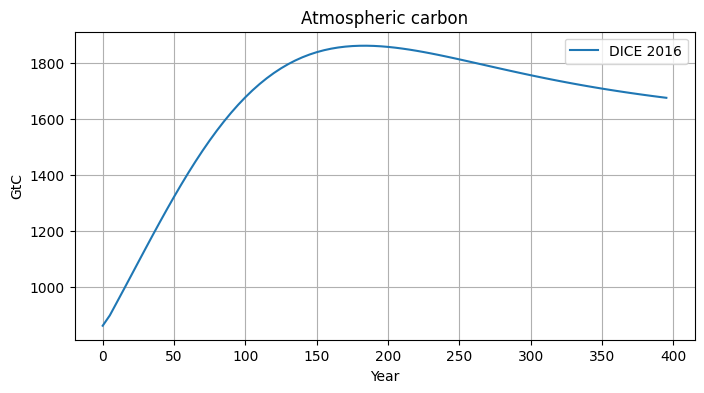

In [22]:
if len(df2016['M_1_t']) >= num_time_steps:
    plt.figure(figsize=(8, 4))
    plt.plot(year_labels, df2016['M_1_t'][:num_time_steps], label='DICE 2016')
    plt.title('Atmospheric carbon')
    plt.xlabel('Year')
    plt.ylabel('GtC')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    raise ValueError(errorstr)

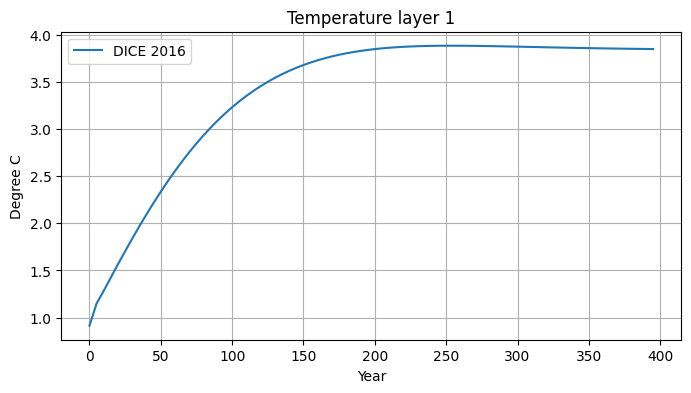

In [23]:
if not len(df2016['tau_1_t']) >= num_time_steps:
    raise ValueError(errorstr)

normal_temperatures = np.log(df2016['tau_1_t'][:num_time_steps]) / env2016.equations_of_motion.xi_1.numpy()

plt.figure(figsize=(8, 4))
plt.plot(year_labels, normal_temperatures, label='DICE 2016')
plt.title('Temperature layer 1')
plt.xlabel('Year')
plt.ylabel('Degree C')
plt.legend()
plt.grid(True)
plt.show()

## probably not gonna use

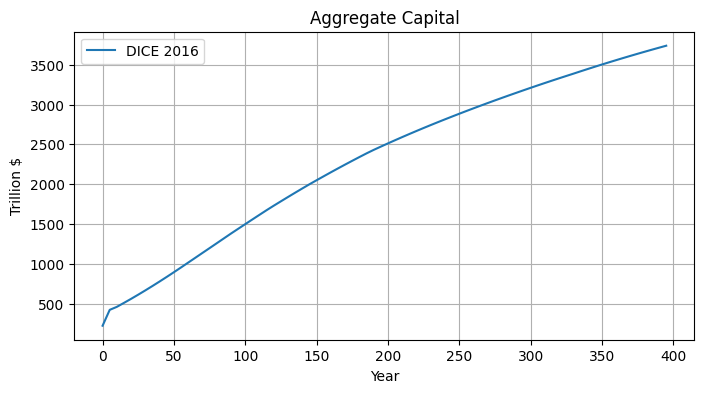

In [24]:
# Plotting capital
if not len(df2016['tau_1_t']) >= num_time_steps:
    raise ValueError(errorstr)

capital = np.exp(df2016["k_t"][:num_time_steps])
plt.figure(figsize=(8, 4))
plt.plot(year_labels, capital, label='DICE 2016')
plt.title('Aggregate Capital')
plt.xlabel('Year')
plt.ylabel('Trillion $')
plt.legend()
plt.grid(True)
plt.show()

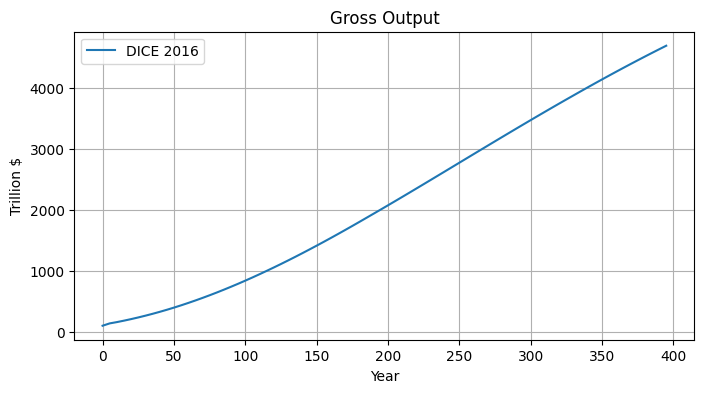

In [25]:
# Plotting output
if not len(df2016['tau_1_t']) >= num_time_steps:
    raise ValueError(errorstr)
k_t_tensor = tf.convert_to_tensor(df2016["k_t"], dtype=tf.float32)
E_t_tensor = tf.convert_to_tensor(df2016["E_t"], dtype=tf.float32)

gross_output = [np.exp(env2016.equations_of_motion.log_Y_t(k_t_tensor[t], E_t_tensor[t], t).numpy()) for t in range(num_time_steps)]
plt.figure(figsize=(8, 4))
plt.plot(year_labels, gross_output, label='DICE 2016')
plt.title('Gross Output')
plt.xlabel('Year')
plt.ylabel('Trillion $')
plt.legend()
plt.grid(True)
plt.show()

# Plotting action variables

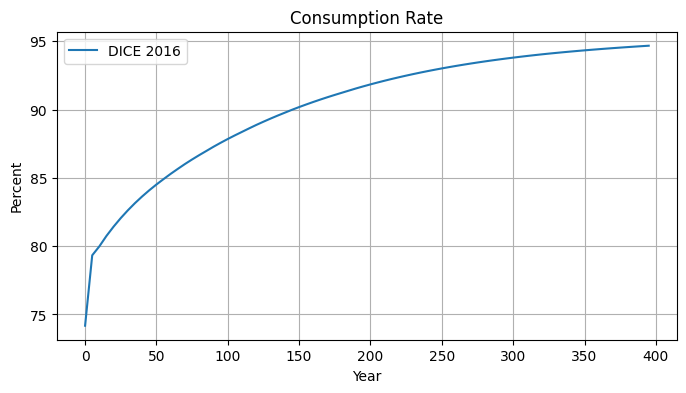

In [26]:
# Plotting consumption
if len(df2016['x_t']) >= num_time_steps:
    
    consumption = df2016['x_t'][:num_time_steps] * 100 # Turning into percent

    plt.figure(figsize=(8, 4))
    plt.plot(year_labels, consumption, label='DICE 2016')
    plt.title('Consumption Rate')
    plt.xlabel('Year')
    plt.ylabel('Percent')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    raise ValueError(errorstr)

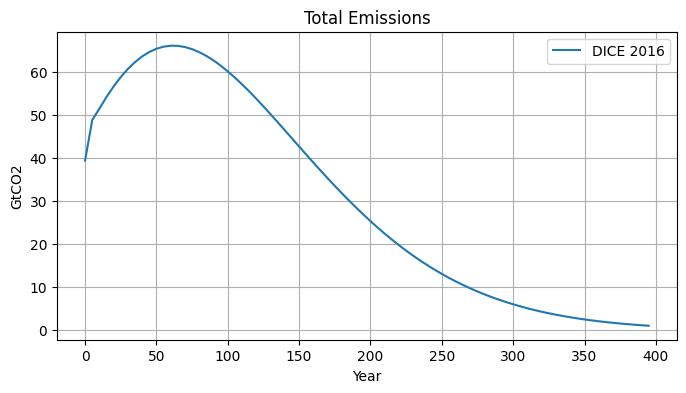

In [27]:
# Plotting emissions
if not len(df2016['E_t']) >= num_time_steps:
    raise ValueError(errorstr)

# Deriving emissions for ACEDICE 2016
emissions = []
for t in range(num_time_steps):
    k_t = tf.convert_to_tensor(df2016["k_t"][t], dtype=tf.float32)
    E_t_BAU = env2016.equations_of_motion.E_t_BAU(t, k_t)
    E_t_raw = tf.convert_to_tensor(df2016["E_t"][t], dtype=tf.float32)
    E_t = custom_sigmoid(E_t_raw, E_t_BAU).numpy()

    total_E_t = E_t + env2016.equations_of_motion.E_t_EXO[t].numpy()
    emissions.append(total_E_t)

emissions = np.array(emissions)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(year_labels, emissions, label='DICE 2016')
plt.title('Total Emissions')
plt.xlabel('Year')
plt.ylabel('GtCO2')
plt.legend()
plt.grid(True)
plt.show()

# Optimality Check

(equation 8): $SCC_t = \frac{\beta^2 Y_t^{net}}{M_{pre}} \xi_0 [(1-\beta\sigma)^{-1}]_{1,1} \sigma^{forc}[(1-\beta\Phi)^{-1}]_{1,1}$

(equation 11): $\mu_t = \left( \frac{\Gamma_t}{p_t^{back}[1-D(T_{1,t})]} \right)^{\frac{1}{\theta_2 - 1}}$, with $\Gamma_t = SCC_t$ in my case, as I don't have any Hotelling rent.

Note, SCC equation in ACE paper (number 11 and number 8 in emissions analysis paper) does not have $\beta^2$, but $\beta$

#### SCC Calculation

In [28]:
# Calculating the temperature dynamics inverse
sigma = env2016.equations_of_motion.sigma_transition
tensor_shape = sigma.shape[0]
ones_matrix = tf.eye(num_rows=tensor_shape, dtype=tf.float32)

matrix_to_invert = ones_matrix - (env2016.equations_of_motion.beta * sigma)
inverse_matrix = tf.linalg.inv(matrix_to_invert)

temp_dyn_inverse = inverse_matrix[0, 0].numpy()

# ---------------------------------- #
# Calculating the carbon dynamics inverse
phi = env2016.equations_of_motion.Phi
tensor_shape = phi.shape[0]
ones_matrix = tf.eye(num_rows=tensor_shape, dtype=tf.float32)

matrix_to_invert = ones_matrix - env2016.equations_of_motion.beta * phi
inverse_matrix = tf.linalg.inv(matrix_to_invert)

carbon_dyn_inverse = inverse_matrix[0, 0].numpy()

print(temp_dyn_inverse, carbon_dyn_inverse)

1.2932322 8.280627


In [29]:
# Constants
xi_0 = env2016.equations_of_motion.xi_0.numpy()
beta_squared = np.square(env2016.equations_of_motion.beta.numpy())
m_pre = env2016.equations_of_motion.M_pre.numpy()
sigma_forc = env2016.equations_of_motion.sigma_forc.numpy()
constant_part = (beta_squared/m_pre)*xi_0 * temp_dyn_inverse * sigma_forc * carbon_dyn_inverse

damages = 1 - np.exp(-xi_0*df2016["tau_1_t"][:num_time_steps]+xi_0)
net_output = gross_output*(np.ones_like(damages)-damages)

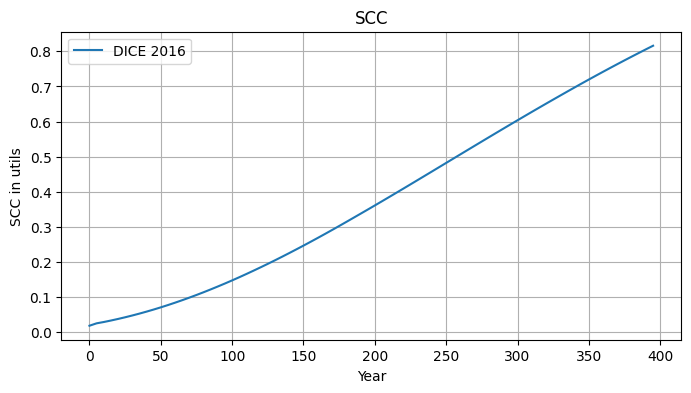

In [30]:
scc = net_output * constant_part
plt.figure(figsize=(8, 4))
plt.plot(year_labels, scc, label='DICE 2016')
plt.title('SCC')
plt.xlabel('Year')
plt.ylabel('SCC in utils')
plt.legend()
plt.grid(True)
plt.show()

## Calculating optimal abatement rate 

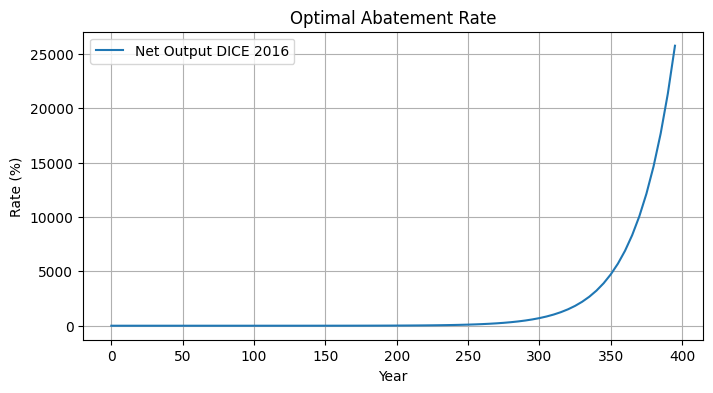

In [31]:
theta_2 = env2016.equations_of_motion.theta_2.numpy()
p_back = env2016.equations_of_motion.pbacktime.numpy()[:num_time_steps]

exponent = 1 / (theta_2 - 1)
optimal_abatement_rate = [np.power(scc[t]/(p_back[t]*(1-damages[t])), exponent) for t in range(num_time_steps)]

plt.figure(figsize=(8, 4))
plt.plot(year_labels, optimal_abatement_rate, label='Net Output DICE 2016')
plt.title('Optimal Abatement Rate')
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Other Checks

## Exogenous Variables

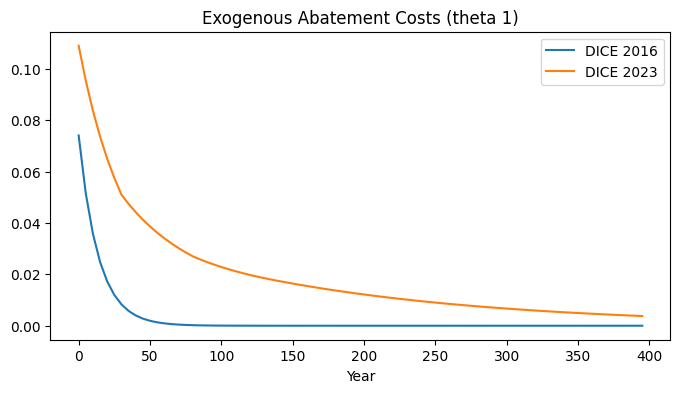

In [36]:
abatementcosts2016 = env2016.equations_of_motion.theta_1.numpy()[:num_time_steps]
abatementcosts2023 = env2023.equations_of_motion.theta_1.numpy()[:num_time_steps]

plt.figure(figsize=(8, 4))
plt.plot(year_labels, abatementcosts2016, label='DICE 2016')
plt.plot(year_labels, abatementcosts2023, label='DICE 2023')
plt.title('Exogenous Abatement Costs (theta 1)')
plt.xlabel('Year')
plt.ylabel('')
plt.legend()
plt.grid(False)
plt.show()

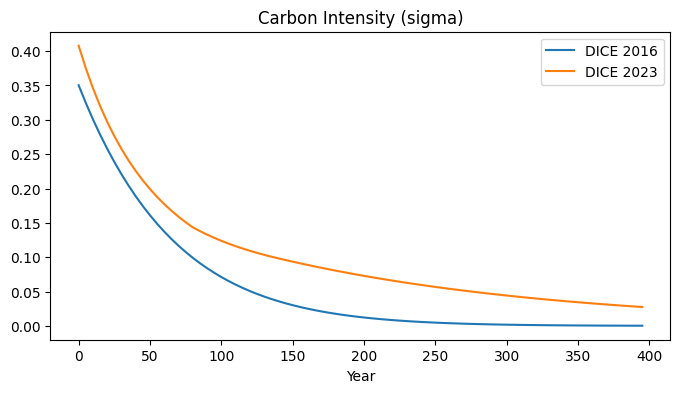

In [38]:
carbon_intensity2016 = env2016.equations_of_motion.sigma.numpy()[:num_time_steps]
carbon_intensity2023 = env2023.equations_of_motion.sigma.numpy()[:num_time_steps]

plt.figure(figsize=(8, 4))
plt.plot(year_labels, carbon_intensity2016, label='DICE 2016')
plt.plot(year_labels, carbon_intensity2023, label='DICE 2023')
plt.title('Carbon Intensity (sigma)')
plt.xlabel('Year')
plt.ylabel('')
plt.legend()
plt.grid(False)
plt.show()

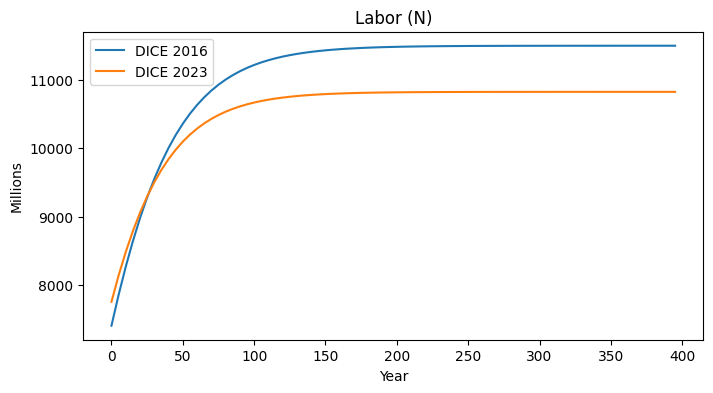

In [39]:
labor2016 = env2016.equations_of_motion.N_t.numpy()[:num_time_steps]
labor2023 = env2023.equations_of_motion.N_t.numpy()[:num_time_steps]

plt.figure(figsize=(8, 4))
plt.plot(year_labels, labor2016, label='DICE 2016')
plt.plot(year_labels, labor2023, label='DICE 2023')
plt.title('Labor (N)')
plt.xlabel('Year')
plt.ylabel('Millions')
plt.legend()
plt.grid(False)
plt.show()

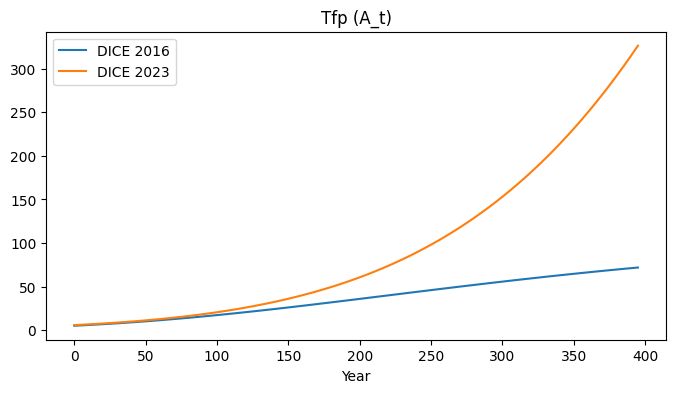

In [41]:
tfp2016 = env2016.equations_of_motion.A_t.numpy()[:num_time_steps]
tfp2023 = env2023.equations_of_motion.A_t.numpy()[:num_time_steps]

plt.figure(figsize=(8, 4))
plt.plot(year_labels, tfp2016, label='DICE 2016')
plt.plot(year_labels, tfp2023, label='DICE 2023')
plt.title('Tfp (A_t)')
plt.xlabel('Year')
plt.ylabel('')
plt.legend()
plt.grid(False)
plt.show()

## Net versus Gross output

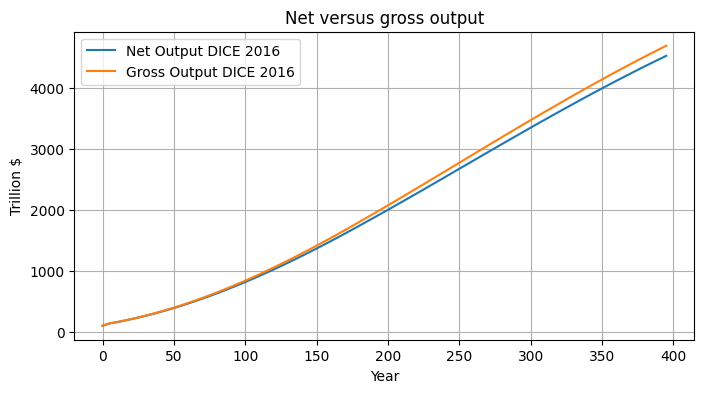

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(year_labels, net_output, label='Net Output DICE 2016')
plt.plot(year_labels, gross_output, label='Gross Output DICE 2016')
plt.title('Net versus gross output')
plt.xlabel('Year')
plt.ylabel('Trillion $')
plt.legend()
plt.grid(True)
plt.show()